In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.svm import NuSVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
pd.set_option('display.max_columns', None)

<h2>SVM Analysis</h2>
This classifier separates data points using a hyperplane with the largest amount of margin. This model finds an optimal hyperplane which can help in classifying new data points. It is often used for classification problems which satisfies our binary classification use case. 

The goal of SVM is to find a maximum marginal hyperplane that best divides the dataset into classes. Support vectors are the data points closest to the hyperplane. 

<strong>How does SVM work?</strong>

[1] Generate hyperplanes which separates the classes in the best way. 
[2] Select the right hyperplane with maximum separation from the nearest points that define the boundary. Given non-linear and inseparable planes, kernal tricks can be used to transform the input space to a higher dimensional space.

<strong>Scikit Learn Tuning Parameters</strong>

[1] From the EDA, it was difficult to see any prominent relationships between the outputs and inputs. For that reason, we test SVC and NuSVC SVM's disregarding LinearSVC. SVC and NuSVC simply vary in their mathematical formulations.

[2] Kernel: Specifies the kernel type to be used in the algorithm. Some possible values are linear, poly, rbf, sigmoid, or precomputed.

[3] C: The strength of regularization => for SVC 

[4] Degree of the polynomial

[5] class_weight: Given that we have many positive and few negative, balancing the class weight might be something of interest.

[6] gamma (scale or auto): Useful for non-linear kernal like RBF. This defines the behavior of the decision boundary.

Sources:
https://scikit-learn.org/stable/modules/svm.html

https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python

<strong>Defining ROC and AUC Score Function</strong>

In [3]:
def predictive_probability_results(y_true, y_prob, label="Model", title="ROC Curve"):
    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [4]:
filename = '/final.csv'
filepath = '/Users/zarahtaufique/Desktop/SJSU/Year4Semester2/CMPE188/kickstarter-project-success-predictions/data'
pd.set_option('display.max_columns', None)

starter_df = pd.read_csv(filepath+filename, low_memory=False)
print(starter_df.columns)

Index(['goal', 'static_usd_rate', 'name_len_clean', 'blurb_len_clean',
       'deadline_month', 'deadline_day', 'deadline_hr', 'created_at_month',
       'created_at_day', 'created_at_hr', 'launched_at_month',
       'launched_at_day', 'launched_at_yr', 'launched_at_hr',
       'create_to_launch_days', 'launch_to_deadline_days',
       'launch_to_state_change_days', 'TOPCOUNTRY', 'LaunchedTuesday',
       'DeadlineWeekend', 'name', 'blurb', 'disable_communication', 'country',
       'currency', 'deadline', 'state_changed_at', 'created_at', 'launched_at',
       'category', 'SuccessfulBool', 'app', 'help', 'new', 'world', 'canceled',
       'country_grouped_CA', 'country_grouped_GB', 'country_grouped_Other',
       'country_grouped_US', 'currency_grouped_CAD', 'currency_grouped_EUR',
       'currency_grouped_GBP', 'currency_grouped_Other',
       'currency_grouped_USD', 'deadline_weekday_Friday',
       'deadline_weekday_Monday', 'deadline_weekday_Saturday',
       'deadline_weekday_Sun

In [5]:
# Dropping columns before training
cols_to_drop = [
    'name',
    'blurb',
    'category',
    'country',
    'currency',
    'deadline',
    'state_changed_at',
    'created_at',
    'launched_at',
    'launch_to_state_change',
    'create_to_launch',
    'launch_to_deadline',
    'currency_grouped',
    'category_grouped',
    'country_grouped',
    'spotlight',
    'usd_pledged', 
    'staff_pick', 
    'backers_count'
]

def safe_drop_columns(df, features_to_drop):
    for column in features_to_drop:
        if column in df.columns.tolist():
            df.drop(column, axis=1, inplace=True)
safe_drop_columns(starter_df, cols_to_drop)
print(starter_df.head())

       goal  static_usd_rate  name_len_clean  blurb_len_clean  deadline_month  \
0 -0.069342        -0.170837               1                0       -1.673181   
1 -0.070091        -0.170837               0                0       -0.500620   
2  0.004414        -0.170837               1                0       -1.086900   
3 -0.066721        -0.170837               0                0        0.965081   
4 -0.068053         0.326589               0                1       -0.207480   

   deadline_day  deadline_hr  created_at_month  created_at_day  created_at_hr  \
0      0.809162    -0.484757          1.352806        1.533348       1.568328   
1     -1.627783     0.509116         -1.337045        0.507876      -0.617699   
2      1.141472    -0.816048         -1.635917        0.963642      -2.131103   
3     -1.073932    -2.141213          0.755061       -1.201244       1.568328   
4      1.252242    -0.153466         -0.440428        1.077583       0.223080   

   launched_at_month  laun

Many columns are labeled with true/false variables. SVMs are mathematical models requiring numerical inputs. 

In [6]:
print(starter_df.dtypes)

goal                          float64
static_usd_rate               float64
name_len_clean                  int64
blurb_len_clean                 int64
deadline_month                float64
                               ...   
category_grouped_Plays          int64
category_grouped_Software       int64
category_grouped_Sound          int64
category_grouped_Wearables      int64
category_grouped_Web            int64
Length: 74, dtype: object


<h3>Preliminary Analysis with Minimal Model Tuning</h3>

In [7]:
# All input features
X = starter_df.drop('SuccessfulBool', axis=1)

# Get the output
Y = starter_df['SuccessfulBool']

models = [
    ('RBF SVC SVM', SVC(kernel='rbf', C=1, random_state=42)), # RBF is the default for SVM
    ('RBF NuSVC SVM', NuSVC(kernel='rbf', random_state=42)),
]

In [55]:
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.4f} accuracy (±{cv_results.std():.4f})")

RBF SVC SVM: 0.7083 accuracy (±0.0039)
RBF NuSVC SVM: 0.7286 accuracy (±0.0190)


<h3>Analysis of Different Kernel Functions</h3>

<strong>Kernal Function Notes</strong>
The kernel function is used to take data as input and transform it into the required form of processing data.

[1] Linear Kernel: This is best suited for data that is linearly separable. Given that this model is two dimensional and we have many input features, I am predicting this model will not accurately predict that test data.

[2] Polynomial Kernel: This allows for mapping of more complex relationships by introducing polynomial terms. This is useful for data that is not linearly separable but still follows a pattern.

[3] RBF Kernel: This is the most widely used kerne;. It maps the data into an infinite-dimensional space marking it highly effective for complex classification problems. We use this when the decision boundary is highly non-linear.

[4] Sigmoid: This is inspired by neural networks. It is suitable for neural networks and non-linear classifiers.

Source: https://www.geeksforgeeks.org/major-kernel-functions-in-support-vector-machine-svm/
A cool video for kernal visualization: https://www.youtube.com/watch?v=3liCbRZPrZA

In [56]:
kernel_results = []
kernel_names = []

model = LinearSVC(random_state=42, max_iter=50000)
cv_results = cross_val_score(model, X, Y, cv=kfold)
print(f"Linear SVC SVM: {cv_results.mean():.4f} accuracy (±{cv_results.std():.4f})")
kernel_results.append(cv_results)
kernel_names.append('Linear SVC SVM')

Linear SVC SVM: 0.7508 accuracy (±0.0056)


In [ ]:
kernel_models = [
    ('Poly SVC SVM', SVC(kernel='poly', C=1, random_state=42)),
    ('Sigmoid SVC SVM', SVC(kernel='sigmoid', C=1, random_state=42)),
    ('Sigmoid NuSVC SVM', NuSVC(kernel='sigmoid', random_state=42)),
    ('Poly NuSVC SVM', NuSVC(kernel='poly', random_state=42)),
]

scoring = 'accuracy'
for name, model in kernel_models:
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=1)
    kernel_results.append(cv_results)
    kernel_names.append(name)
    print(f"{name}: {cv_results.mean():.4f} accuracy (±{cv_results.std():.4f})")

Poly SVC SVM: 0.7086 accuracy (±0.0040)
Sigmoid SVC SVM: 0.6248 accuracy (±0.0262)
Sigmoid NuSVC SVM: 0.5747 accuracy (±0.0115)
Poly NuSVC SVM: 0.7081 accuracy (±0.0092)


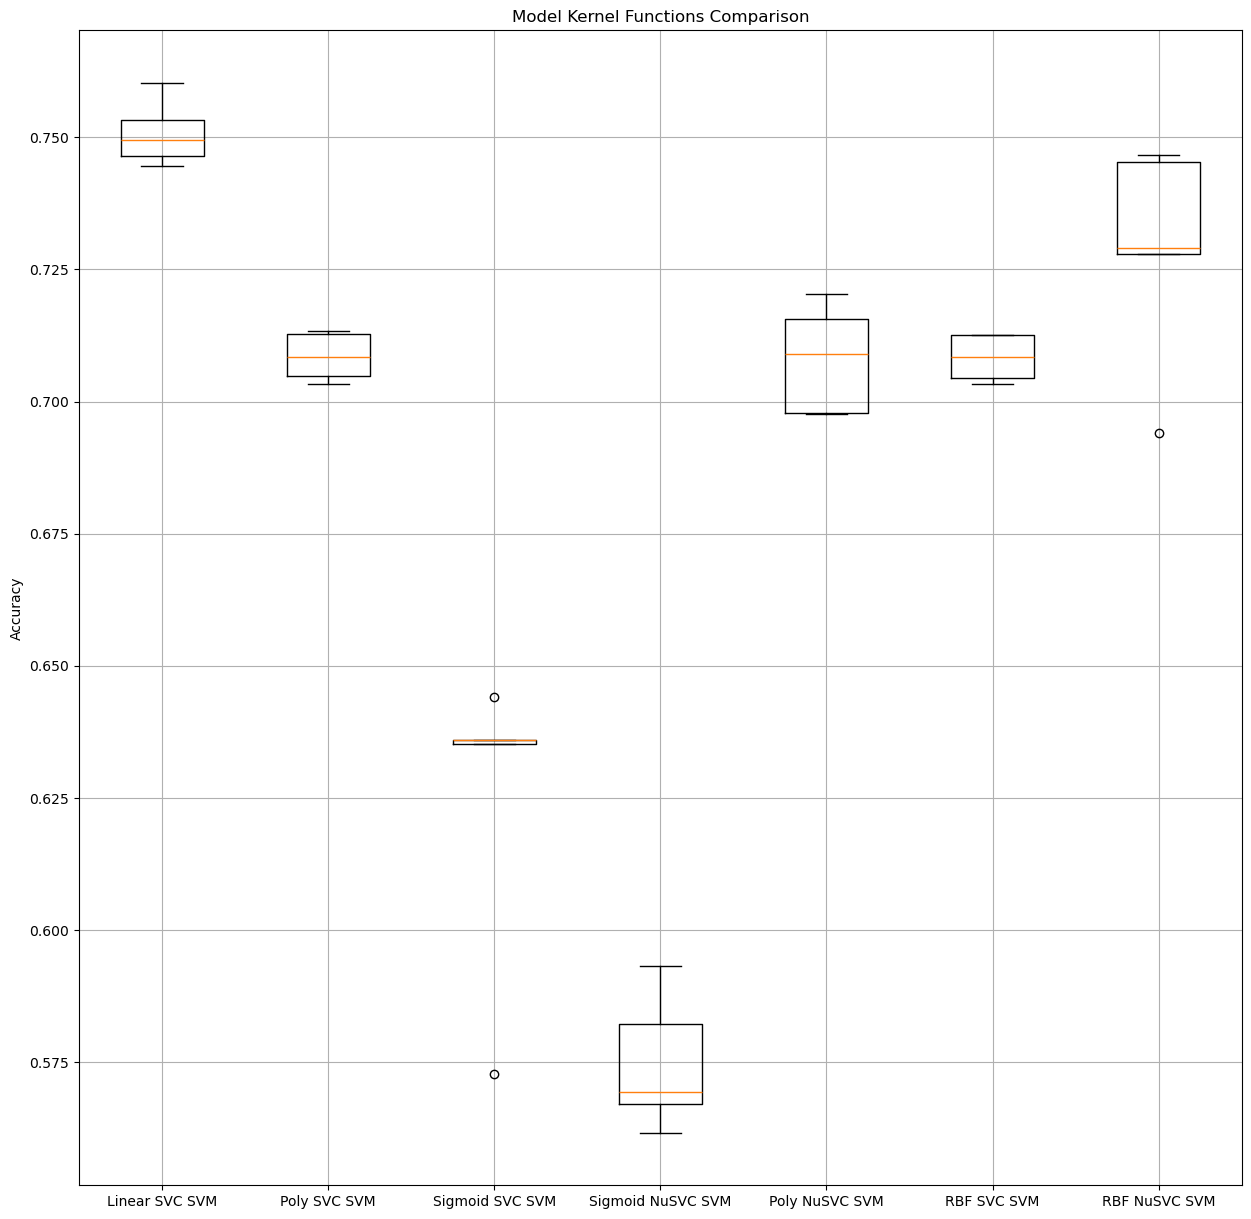

In [58]:
plt.figure(figsize=(15, 15))
plt.boxplot(kernel_results + results)
plt.title('Model Kernel Functions Comparison')
plt.ylabel('Accuracy')
all_names = kernel_names + names
plt.xticks(range(1, len(all_names) + 1), all_names)
plt.grid(True)
plt.show()

Here we see that Linear SVC SVM is the best performer. This is interesting because our the correlation matrix showed the relationship between the features and target variables was non-linear and given many dimensions, I expected that a higher dimensional space would be required to achieve a high model accuracy. Linear SVMs tend to generalize better in high dimensions because they are simpler and more regularized. RBF needs careful hyperparameter tuning; without it, the model can be too flexible or too rigid. RBF is better in terms of model accuracy with default parameters than Poly NuSVM as seen by the distribution of the boxplot. We see that the folds are performing very similarly with no outliers whereas the range of performance for Poly NuSVM is greater. 

Further analysis such as looking at the ROC and AUC scores of these classification models is required.

<h3>Analysis of Regularization Parameter for SVCs</h3>

<strong>Background</strong>

The parameter C is used to set the amount of regularization, or a technqiue to reduce overfitting. C controls the trade-off between margin width and classification error.
Given that the Poly SVC model seems to be overfitted, we will test different regularization amounts for Poly SVC and RBF SVC (previously model accurate model). 

A low C indicates a larger margin and a model that is more tolerant for misclassification. A high C has more narrow margin making it less tolerant for error.

Source: 
https://scikit-learn.org/stable/auto_examples/svm/plot_svm_scale_c.html#sphx-glr-auto-examples-svm-plot-svm-scale-c-py

<strong>Regularization Tuning for RBF SVC Functions</strong>

In [59]:
# Tested multiple times with C less than 1 and it does not seem to be a good fit for this data
C_values = [1, 10, 100, 1000]
rbf_regularization_results = []

for C in C_values:
    model = SVC(kernel='rbf', C=C, random_state=42)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
    rbf_regularization_results.append(cv_results)
    print(f"C={C}: Mean accuracy = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")

C=1: Mean accuracy = 0.7083, Std = 0.0039
C=10: Mean accuracy = 0.7080, Std = 0.0042
C=100: Mean accuracy = 0.7368, Std = 0.0085
C=1000: Mean accuracy = 0.7467, Std = 0.0052


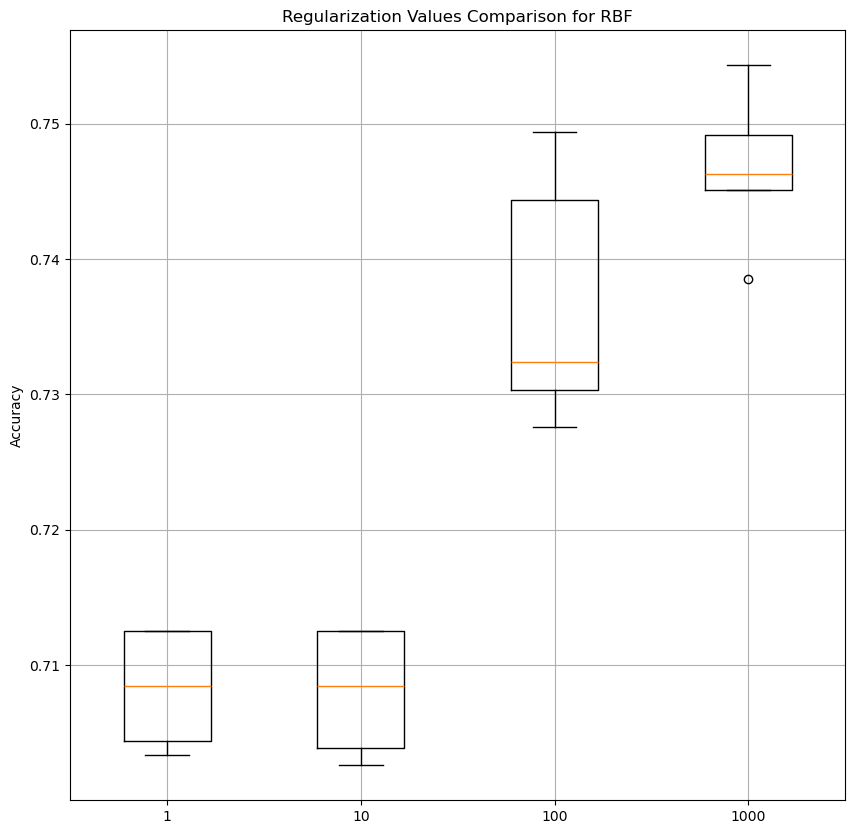

In [60]:
plt.figure(figsize=(10, 10))
plt.boxplot(rbf_regularization_results)
plt.title('Regularization Values Comparison for RBF')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(C_values) + 1), C_values)
plt.grid(True)
plt.show()

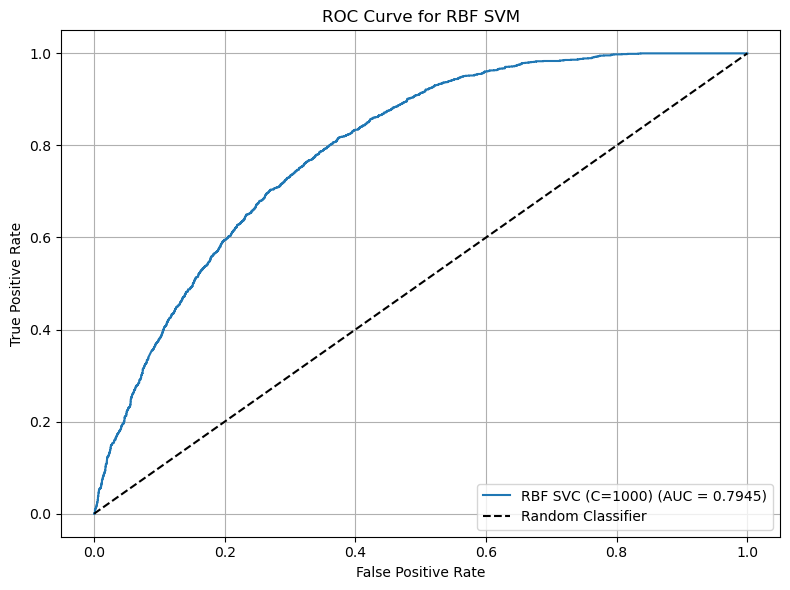

In [61]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Fit model
model = SVC(kernel='rbf', C=1000, probability=True, random_state=42)
model.fit(X_train, y_train)

# Predict probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# Plot ROC
predictive_probability_results(y_test, y_proba, label="RBF SVC (C=1000)", title="ROC Curve for RBF SVM")

For RBF SWM, we see that as C increases, but a C value of 1000 yields an outlier in the CV performance. The standard deviations are quite low for the models but the graph reveals some variance between buckets.

We also observe the ROC/AUC score for the model with C=1000. The AUC score indicates that the model is fairly accurate, inbetween random guessing and making accurate predictions. However, given other tuning paramters there is room for improvement.

<strong>Regularization Tuning for Poly SVC Functions</strong>

In [64]:
C_values = [1, 10, 100, 1000]
poly_regularization_results = []

# All input features
X = starter_df.drop('SuccessfulBool', axis=1)

# Get the output
Y = starter_df['SuccessfulBool']

for C in C_values:
    model = SVC(kernel='poly', C=C, random_state=42)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
    poly_regularization_results.append(cv_results)
    print(f"C={C}: Mean accuracy = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")

C=1: Mean accuracy = 0.7086, Std = 0.0040
C=10: Mean accuracy = 0.7081, Std = 0.0042
C=100: Mean accuracy = 0.7077, Std = 0.0042


The data does not seem to be overfitted as with varying values of regularization, the model performs consistently around 71% accuracy with relatively low standard deviation. It might be worth adjusting the gamma coefficient before ruling out this kernel completely.

In NuSVC, the nu parameter defines an upper bound on the fraction of margin errors and a lower bound on the fraction of support vectors.
For example, setting nu = 0.4 guarantees that no more than 40% of the training data will be margin violators, and at least 40% will be support vectors

Source: https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html

In [65]:
nu_value = [0.5, 0.4, 0.3]
poly_nu_regularization_results = []

for nu in nu_value:
    model = NuSVC(kernel='poly', nu=nu, random_state=42)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy', n_jobs=1)
    poly_nu_regularization_results.append(cv_results)
    print(f"Nu={nu}: Mean accuracy = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")

Nu=0.5: Mean accuracy = 0.7081, Std = 0.0092
Nu=0.4: Mean accuracy = 0.5377, Std = 0.2008
Nu=0.3: Mean accuracy = 0.4112, Std = 0.1503


We see that varying the nu value yeilds very different accuracy results peaking with a nu value of 0.5. The standard deviation for this point is quite low as well telling us the models are performing similary across buckets. A greater nu value indicates that our model performs well with more support vectors and fewer margin errors. 

<h3>Analysis of Hyperparameters for SVCs using Grid Search</h3>
<strong>Gamma Parameter Notes</strong>
This play a crucial role in defing the behavior of the decision boundary. 

A low gamma means the influence of a single training example reach far and affects a larger region of feature space. This means smoother and less complex decision boundaries. This can lead to underfitting.

A high gamma makes the decision boundary very tight around individual data points. This can lead to overfitting where the model captures noize and responds poorly to new, unseen data.

The default value of gamma is scale which is dependent on the features and variance. Auto is simply dependent on the features ignoring the actual data distribution. 

Source: https://www.geeksforgeeks.org/gamma-parameter-in-svm/


In [66]:
# All input features
X = starter_df.drop('SuccessfulBool', axis=1)

# Get the output
Y = starter_df['SuccessfulBool']

param_grid = {
    'kernel': ['linear'],
    # Completed so many tests with less than 1, does not seem to work well with the data
    'C': [1, 10, 100, 1000],
}

svc = SVC(random_state=42)

grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kfold,
    verbose=2
)

grid_search.fit(X, Y)

# Convert cv_results_ to a DataFrame
linear_results_df = pd.DataFrame(grid_search.cv_results_)

# Sort by mean test score descending
linear_sorted_results = linear_results_df.sort_values(by='mean_test_score', ascending=False)

# Display top 10 combinations
print("\nTop 10 Grid Search Results:")
print(linear_sorted_results[['mean_test_score', 'std_test_score', 'params']].head(10))

# Best combination and accuracy
print("\nBest Parameters Found:")
print(grid_search.best_params_)

print("\nBest Cross-Validation Accuracy: {:.4f}".format(grid_search.best_score_))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .................................C=1, kernel=linear; total time= 2.0min
[CV] END .................................C=1, kernel=linear; total time= 2.2min
[CV] END .................................C=1, kernel=linear; total time= 2.9min
[CV] END .................................C=1, kernel=linear; total time= 1.9min
[CV] END .................................C=1, kernel=linear; total time= 1.6min
[CV] END ................................C=10, kernel=linear; total time= 6.6min
[CV] END ................................C=10, kernel=linear; total time= 6.2min
[CV] END ................................C=10, kernel=linear; total time= 7.7min
[CV] END ................................C=10, kernel=linear; total time= 6.8min
[CV] END ................................C=10, kernel=linear; total time= 6.6min
[CV] END ...............................C=100, kernel=linear; total time=23.5min
[CV] END ...............................C=100, ke

In [68]:
param_grid = {
    'kernel': ['poly'],
    'C': [1, 10, 100, 1000],
    'degree': [2, 3, 4],
}

svc = SVC(random_state=42)

grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kfold,
    verbose=2
)

grid_search.fit(X, Y)

poly_results_df = pd.DataFrame(grid_search.cv_results_)

poly_sorted_results = poly_results_df.sort_values(by='mean_test_score', ascending=False)

print("\nTop 10 Grid Search Results:")
print(poly_sorted_results[['mean_test_score', 'std_test_score', 'params']].head(10))

# Best combination and accuracy
print("\nBest Parameters Found:")
print(grid_search.best_params_)

print("\nBest Cross-Validation Accuracy: {:.4f}".format(grid_search.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .........................C=1, degree=2, kernel=poly; total time=  16.5s
[CV] END .........................C=1, degree=2, kernel=poly; total time=  16.1s
[CV] END .........................C=1, degree=2, kernel=poly; total time=  20.1s
[CV] END .........................C=1, degree=2, kernel=poly; total time=  21.4s
[CV] END .........................C=1, degree=2, kernel=poly; total time=  23.0s
[CV] END .........................C=1, degree=3, kernel=poly; total time=  41.0s
[CV] END .........................C=1, degree=3, kernel=poly; total time= 1.1min
[CV] END .........................C=1, degree=3, kernel=poly; total time=  37.9s
[CV] END .........................C=1, degree=3, kernel=poly; total time=  47.4s
[CV] END .........................C=1, degree=3, kernel=poly; total time=  38.1s
[CV] END .........................C=1, degree=4, kernel=poly; total time= 5.8min
[CV] END .........................C=1, degree=4,

In [69]:
param_grid = {
    'kernel': ['rbf'],
    'C': [1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.01],
}

svc = SVC(random_state=42)

grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kfold,
    verbose=2
)

grid_search.fit(X, Y)

# Convert cv_results_ to a DataFrame
rbf_results_df = pd.DataFrame(grid_search.cv_results_)

# Sort by mean test score descending
rbf_sorted_results = rbf_results_df.sort_values(by='mean_test_score', ascending=False)

# Display top 10 combinations
print("\nTop 10 Grid Search Results:")
print(rbf_sorted_results[['mean_test_score', 'std_test_score', 'params']].head(10))

# Best combination and accuracy
print("\nBest Parameters Found:")
print(grid_search.best_params_)

print("\nBest Cross-Validation Accuracy: {:.4f}".format(grid_search.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   8.7s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   8.5s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   8.5s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   9.0s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   9.3s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=  11.0s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=  10.5s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=  10.4s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=  10.1s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=  10.5s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   9.8s
[CV] END ........................C=1, gamma=0.01

<h3>Summary of Results from GridCV</h3>

<strong>RBF Kernel</strong>

Best Parameters Found:
{'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}

Best Cross-Validation Accuracy: 0.7467 Mean STD: 0.003146

<strong>Poly Kernel</strong>

Best Parameters Found:
{'C': 1000, 'degree': 2, 'kernel': 'poly'}

Best Cross-Validation Accuracy: 0.7164 Mean STD: 0.006068

<strong>Linear Kernel</strong>

Best Parameters Found:
{'C': 10, 'kernel': 'linear'}

Best Cross-Validation Accuracy: 0.7475 Mean STD: 0.005177

<h3>Analysis of Results from GridCV</h3>

Here, we see Linear kernel is the top performer out of the other kernels. We see that linear benefits from a 'medium' sized margin allowing some misclassifications. RBF and Poly benefit from a much smaller margin allowing less misclassifications. Having a smaller marigin runs the risk of misclassification which might explain why these kernels performed worse than the linear kernel. Overall, beceause we are seeing an about ~70% accuracy across kernels, this may indicate given the data we have, there is simply not enough data to accurately classify whether or not a kickstarter campaign will succeed at launch. 

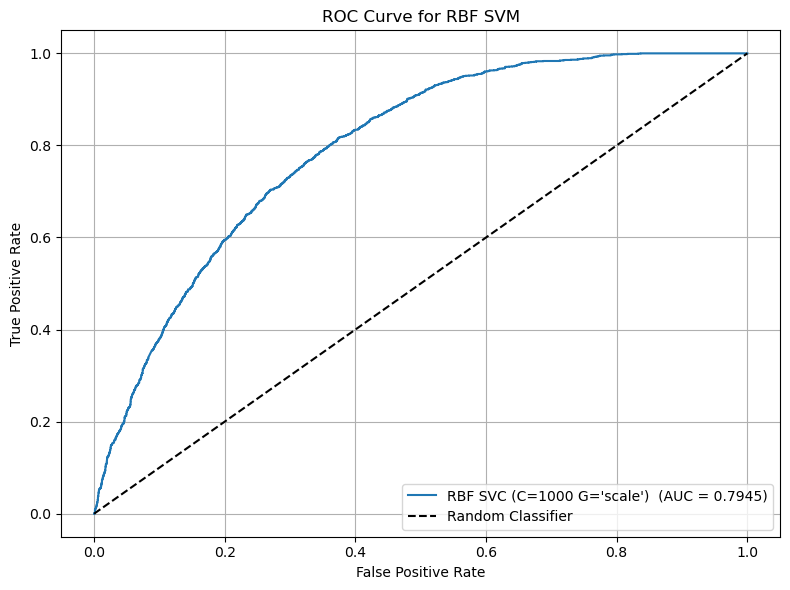

In [73]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Fit model
model = SVC(kernel='rbf', C=1000, gamma='scale', probability=True, random_state=42)
model.fit(X_train, y_train)

# Predict probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# Plot ROC
predictive_probability_results(y_test, y_proba, label="RBF SVC (C=1000 G='scale') ", title="ROC Curve for RBF SVM")

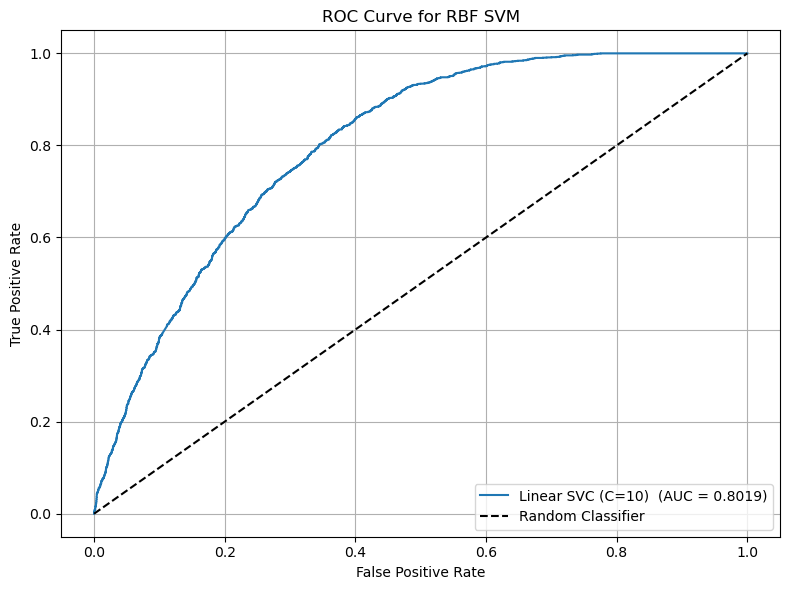

In [74]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Fit model
model = SVC(kernel='linear', C=10, probability=True, random_state=42)
model.fit(X_train, y_train)

# Predict probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# Plot ROC
predictive_probability_results(y_test, y_proba, label="Linear SVC (C=10) ", title="ROC Curve for RBF SVM")

<h3>Summary of Results from ROC Curve/AUC Score</h3>

We see that RBF and Linear SVC yield a similar AUC score. A linear kernel, though, performs slightly better. The score indicates that our model is inbetween pure guessing and perfect performance. This is considered an acceptable score, but not a great model.

From the initial analysis, we see that LinearSVC performs better than SVC with different kernels. Below, we perform a GridSearchCV analysis for LinearSVC.

In [8]:
# All input features
X = starter_df.drop('SuccessfulBool', axis=1)

# Get the output
Y = starter_df['SuccessfulBool']

param_grid = {
    'C': [1, 10, 100],
    'class_weight': [None, 'balanced'] # None is the default for class weights
}

svc = LinearSVC(random_state=42)

grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kfold,
    verbose=2
)

grid_search.fit(X, Y)

# Convert cv_results_ to a DataFrame
linear_svc_results_df = pd.DataFrame(grid_search.cv_results_)

# Sort by mean test score descending
linear_svc_sorted_results = linear_svc_results_df.sort_values(by='mean_test_score', ascending=False)

# Display top 10 combinations
print("\nTop 10 Grid Search Results:")
print(linear_svc_sorted_results[['mean_test_score', 'std_test_score', 'params']].head(10))

# Best combination and accuracy
print("\nBest Parameters Found:")
print(grid_search.best_params_)

print("\nBest Cross-Validation Accuracy: {:.4f}".format(grid_search.best_score_))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .............................C=1, class_weight=None; total time=   0.1s
[CV] END .............................C=1, class_weight=None; total time=   0.2s
[CV] END .............................C=1, class_weight=None; total time=   0.2s
[CV] END .............................C=1, class_weight=None; total time=   0.3s
[CV] END .............................C=1, class_weight=None; total time=   0.3s
[CV] END .........................C=1, class_weight=balanced; total time=   0.3s
[CV] END .........................C=1, class_weight=balanced; total time=   0.4s
[CV] END .........................C=1, class_weight=balanced; total time=   0.4s
[CV] END .........................C=1, class_weight=balanced; total time=   0.3s
[CV] END .........................C=1, class_weight=balanced; total time=   0.4s
[CV] END ............................C=10, class_weight=None; total time=   0.1s
[CV] END ............................C=10, class_

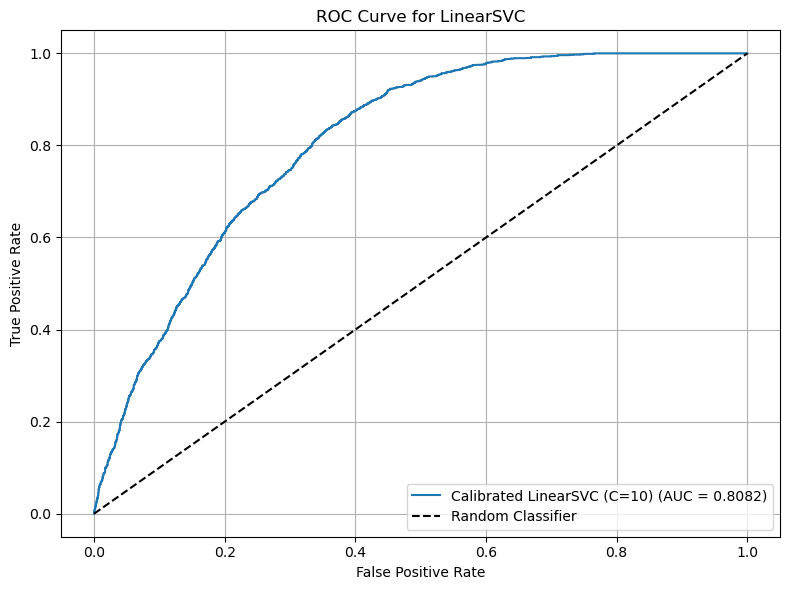

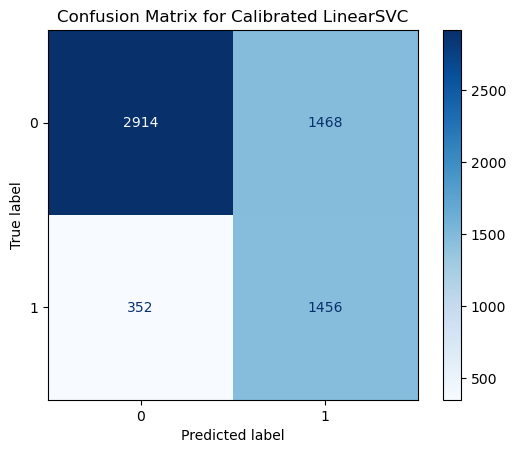

In [10]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Use CalibratedClassifierCV to get probabilities from LinearSVC
base_model = LinearSVC(C=10, random_state=42, max_iter=10000)
model = CalibratedClassifierCV(base_model, cv=5)  # adds predict_proba support

# Fit
model.fit(X_train, y_train)

# Predict probabilities
y_proba = model.predict_proba(X_test)[:, 1]

# Plot ROC
predictive_probability_results(y_test, y_proba, label="Calibrated LinearSVC (C=10)", title="ROC Curve for LinearSVC")

# Convert probabilities to class labels
y_pred = (y_proba >= 0.3).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Calibrated LinearSVC")
plt.show()

We see that out of all Support Vector Classifier models, the LinearSVC with C=10 yields the highest AUC score and an accuracy of 75.11%. Since LinearSVC does not provide continuous probability outputs, this can explain why the ROC curve appears slightly jagged. Although the dataset has many features, the classes may actually separate more clearly with a linear boundary in the high-dimensional space. In contrast, non-linear models like RBF or polynomial kernels are more complex and tend to require tighter margins and more precise tuning to reach accuracy levels comparable to the linear model.